In [ ]:
# Unet with ResNet 34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [2]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath =  dataPath + '/Train'
testPath  =  dataPath + '/Test'
valPath   =  dataPath + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs = getData(trainPath, trainImgsFile)
trainLabels = getData(trainPath, trainLabelsFile)

#testImgs   = getData(testPath, testImgsFile)
#testLabels = getData(testPath, testLabelsFile)

valImgs    = getData(valPath, valImgsFile)
valLabels  = getData(valPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)

Got train and validation data
(1000, 480, 320, 1) (251, 480, 320, 1)
(1000, 480, 320, 1) (251, 480, 320, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
# BATCH_SIZE = 16
# EPOCHS     = 20 (use early stopping as well to avoid overfitting (and store the epochs till then))
import os
import numpy as np
import segmentation_models as sm

# create the model
model = sm.Unet('resnet152', input_shape=(480, 320, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [3]:
# Compile the model with loss function, optimizer and metric
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    'Adam',
    loss='sparse_categorical_crossentropy',
    metrics=[sm.metrics.iou_score,'accuracy'],
)

In [4]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [5]:
# Start training the model

# change the label type to float32
# tf.cast(trainLabels, tf.float32)
# tf.cast(trainImgs, tf.float32)
# tf.cast(valLabels, tf.float32)
# tf.cast(valImgs, tf.float32)

history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 89s 89ms/sample - loss: 0.7504 - iou_score: 0.0550 - accuracy: 0.8804 - val_loss: 0.6179 - val_iou_score: 0.0260 - val_accuracy: 0.9621
Epoch 2/30
1000/1000 [==============================] - 57s 57ms/sample - loss: 0.1428 - iou_score: 0.0654 - accuracy: 0.9699 - val_loss: 0.1778 - val_iou_score: 0.0473 - val_accuracy: 0.9671
Epoch 3/30
1000/1000 [==============================] - 57s 57ms/sample - loss: 0.1055 - iou_score: 0.0898 - accuracy: 0.9741 - val_loss: 0.2633 - val_iou_score: 0.0428 - val_accuracy: 0.9404
Epoch 4/30
1000/1000 [==============================] - 57s 57ms/sample - loss: 0.0911 - iou_score: 0.0927 - accuracy: 0.9761 - val_loss: 0.3502 - val_iou_score: 0.0370 - val_accuracy: 0.9658
Epoch 5/30
1000/1000 [==============================] - 57s 57ms/sample - loss: 0.0811 - iou_score: 0.0955 - accuracy: 0.9774 - val_loss: 0.0980 - val_iou_score: 0.1151 - val_accuracy: 

dict_keys(['loss', 'iou_score', 'accuracy', 'val_loss', 'val_iou_score', 'val_accuracy'])


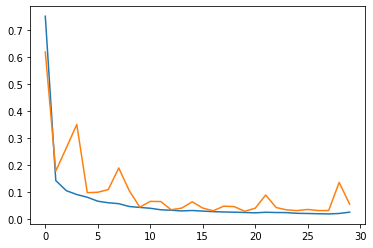

In [7]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

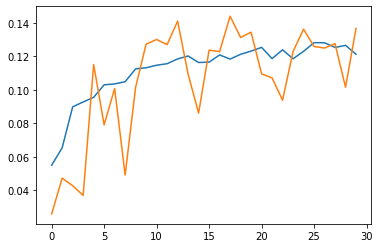

In [9]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])

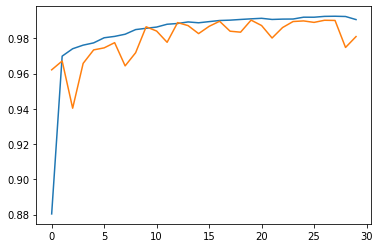

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [11]:
# get the testdata
testImgs   = getData(testPath, testImgsFile)
testLabels = getData(testPath, testLabelsFile)

In [12]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 19s 30ms/sample - loss: 0.0528 - iou_score: 0.1357 - accuracy: 0.9823


[0.05282980283326809, 0.13566175, 0.98230314]

In [13]:
# save the model weights
weightFileName = "UResNet152_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/UNET'
model.save_weights(weightPath + "/" + weightFileName)


In [14]:
model.load_weights(weightPath + "/" + weightFileName)
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 9s 15ms/sample - loss: 0.0528 - iou_score: 0.1357 - accuracy: 0.9823


[0.05282980283326809, 0.13566175, 0.98230314]

In [15]:
modelFileName = "UResNet152_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet'
model.save(modelPath + "/" + modelFileName)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Underwater_Segmentation_Research/Models/Unet/UResNet152_30e_16b/assets


In [16]:
# Check the GPU configuration
!nvidia-smi

Tue Mar 30 07:53:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   8802MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# check the outputs here
outputs = model.predict(testImgs)

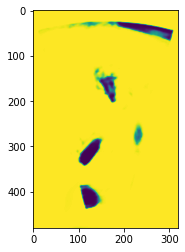

In [18]:
import matplotlib.pyplot as plt

img = outputs[0,:,:,0]
plt.imshow(img)
plt.show()

In [37]:
outputs = None
testImgs = None
testLabels = None